In [46]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud_fa import WordCloudFa
from arabic_reshaper import reshape
from bidi.algorithm import get_display
from hazm import *
from nltk.util import ngrams

In [2]:
model_name = "HooshvareLab/bert-fa-base-uncased-sentiment-deepsentipers-multi"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

c:\Users\Mostafa\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
c:\Users\Mostafa\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\utils\generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [3]:
def preprocess(sentences, tokenizer, max_length=256):
    encoding = tokenizer(
        sentences,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )
    return encoding


def predict_in_batches(sentiments, model, tokenizer, batch_size=32):
    model.eval()
    all_predictions = []
    
    for i in range(0, len(sentiments), batch_size):
        batch = sentiments[i:i + batch_size]
        inputs = preprocess(batch, tokenizer)
        with torch.no_grad():
            outputs = model(**inputs)
            predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
            all_predictions.extend(predictions)
    
    return torch.stack(all_predictions)

def get_sentiment_labels(predictions):
    labels = ['Furious', 'Angry', 'Neutral', 'Happy', 'Delighted']
    sentiment_labels = []
    for prediction in predictions:
        label_id = torch.argmax(prediction).item()
        sentiment_labels.append(labels[label_id])
    return sentiment_labels




In [4]:
df = pd.read_json(r'data/PP-data.json')
df.head()

,dict_id,date,text,persian_year,persian_month,persian_day,hour,day_of_week,PP_text,length,num_tokens,lemma_text,stem_text
0,4,2023-03-09 01:37:38,امروز؛ سحرگاه ۱۸ام اسفندماه، فرزند دومم متولد شد.,1401,12,18,1,Thursday,امروز؛ سحرگاه ۱۸ام اسفندماه فرزند دومم متولد شد,48,10,امروز سحرگاه ۱۸ ام اسفندماه فرزند دوم متولد,امروز سحرگاه ۱۸ ا اسفندماه فرزند دوم متولد
1,7,2023-03-09 02:11:02,من کیستم؟\n\nمبر ز موی سپیدم گمان به عمر دراز\...,1401,12,18,2,Thursday,من کیستم مبر ز موی سپیدم گمان به عمر درازجوان ...,189,36,کیستم مبر ز مو سپید گمان عمر درازجوان ز حادث پ...,کیس مبر ز مو سپید گ عمر درازجو ز حادث پیر میشو...
2,8,2023-03-09 02:20:06,['شاید به دردتان خورد:\n\nبداهه یا حرف\u200cها...,1401,12,18,2,Thursday,شاید به دردتان خورد بداهه یا حرفهای روزمره ຯپ...,298,54,درد خورد بداهه حرف روزمره ຯپسرام هیونگی گرگ এل...,درد خورد بداهه حرف روزمره ຯپسرا هیونگ گرگ এلحظ...
3,9,2023-03-09 16:00:14,سلام بر راه، که جدایی و وصال همگان از اوست!,1401,12,18,16,Thursday,سلام بر راه که جدایی و وصال همگان از اوست,42,10,سلام جدایی وصال همگان اوست,سلا جدا وصال همگ اوس
4,10,2023-03-09 17:54:51,این دفعه، زمان بیشتری رو توی تاریکی می‌گذرونیم.,1401,12,18,17,Thursday,این دفعه زمان بیشتری رو توی تاریکی میگذرونیم,45,8,دفعه زمان تو تاریکی میگذرونیم,دفعه ز تو تاریک میگذرون


In [5]:
sentences = df['PP_text'].tolist()
predictions = predict_in_batches(sentences, model, tokenizer)
sentiment_labels = get_sentiment_labels(predictions)

df['sentiment'] = sentiment_labels



In [3]:
# df.to_json('data/SA-data.json')


df = pd.read_json(r'data/SA-data.json')
df.head()


,dict_id,date,text,persian_year,persian_month,persian_day,hour,day_of_week,PP_text,length,num_tokens,lemma_text,stem_text,sentiment
0,4,2023-03-09 01:37:38,امروز؛ سحرگاه ۱۸ام اسفندماه، فرزند دومم متولد شد.,1401,12,18,1,Thursday,امروز؛ سحرگاه ۱۸ام اسفندماه فرزند دومم متولد شد,48,10,امروز سحرگاه ۱۸ ام اسفندماه فرزند دوم متولد,امروز سحرگاه ۱۸ ا اسفندماه فرزند دوم متولد,Neutral
1,7,2023-03-09 02:11:02,من کیستم؟\n\nمبر ز موی سپیدم گمان به عمر دراز\...,1401,12,18,2,Thursday,من کیستم مبر ز موی سپیدم گمان به عمر درازجوان ...,189,36,کیستم مبر ز مو سپید گمان عمر درازجوان ز حادث پ...,کیس مبر ز مو سپید گ عمر درازجو ز حادث پیر میشو...,Furious
2,8,2023-03-09 02:20:06,['شاید به دردتان خورد:\n\nبداهه یا حرف\u200cها...,1401,12,18,2,Thursday,شاید به دردتان خورد بداهه یا حرفهای روزمره ຯپ...,298,54,درد خورد بداهه حرف روزمره ຯپسرام هیونگی گرگ এل...,درد خورد بداهه حرف روزمره ຯپسرا هیونگ گرگ এلحظ...,Neutral
3,9,2023-03-09 16:00:14,سلام بر راه، که جدایی و وصال همگان از اوست!,1401,12,18,16,Thursday,سلام بر راه که جدایی و وصال همگان از اوست,42,10,سلام جدایی وصال همگان اوست,سلا جدا وصال همگ اوس,Neutral
4,10,2023-03-09 17:54:51,این دفعه، زمان بیشتری رو توی تاریکی می‌گذرونیم.,1401,12,18,17,Thursday,این دفعه زمان بیشتری رو توی تاریکی میگذرونیم,45,8,دفعه زمان تو تاریکی میگذرونیم,دفعه ز تو تاریک میگذرون,Angry


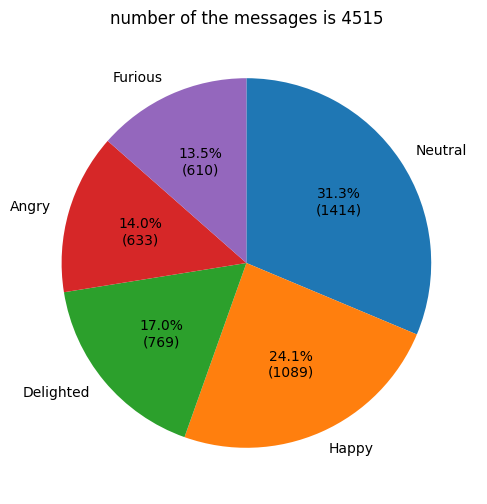

In [19]:
def func(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sentiment_counts = df['sentiment'].value_counts()
plt.figure(figsize=(6, 6))
sentiment_counts.plot(kind='pie', autopct=lambda pct: func(pct, sentiment_counts), startangle=90, counterclock=False)
plt.ylabel('')
plt.title(f'number of the messages is {len(df)}')
plt.show()

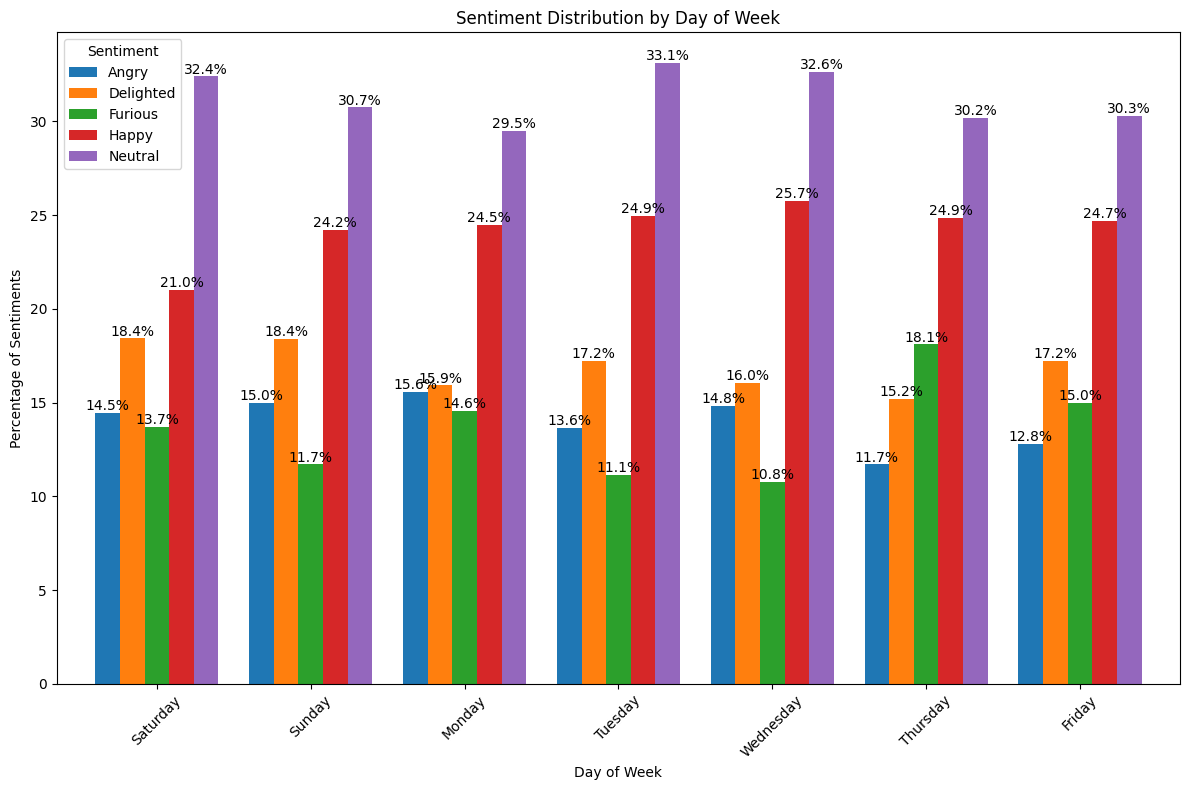

In [35]:
custom_order = ['Saturday','Sunday' , 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=custom_order, ordered=True)

grouped = df.groupby(['day_of_week', 'sentiment']).size().unstack(fill_value=0)

grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

ax = grouped_percent.plot(kind='bar', figsize=(12, 8), width=0.8)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.xlabel('Day of Week')
plt.ylabel('Percentage of Sentiments')
plt.title('Sentiment Distribution by Day of Week')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
df.loc[(df['hour']<=5),'time']='night'
df.loc[((df['hour']>5) & (df['hour']<=10)),'time']='sunrise'
df.loc[((df['hour']>10) & (df['hour']<=16)),'time']='noon'
df.loc[((df['hour']>16) & (df['hour']<=21)),'time']='after noon'
df.loc[((df['hour']>21)),'time']='mid night'



df.loc[(df['persian_day']<=6),'week_no']='first'
df.loc[((df['persian_day']>6) & (df['persian_day']<=12)),'week_no']='second'
df.loc[((df['persian_day']>12) & (df['persian_day']<=18)),'week_no']='third'
df.loc[((df['persian_day']>18) & (df['persian_day']<=24)),'week_no']='fourth'
df.loc[((df['persian_day']>24)),'week_no']='fifth'

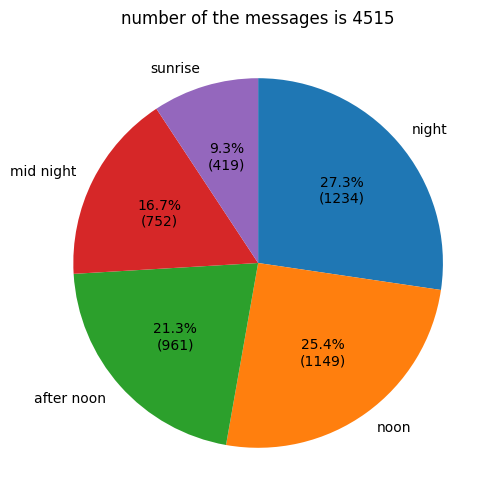

In [31]:
def func(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sentiment_counts = df['time'].value_counts()
plt.figure(figsize=(6, 6))
sentiment_counts.plot(kind='pie', autopct=lambda pct: func(pct, sentiment_counts), startangle=90, counterclock=False)
plt.ylabel('')
plt.title(f'number of the messages is {len(df)}')
plt.show()

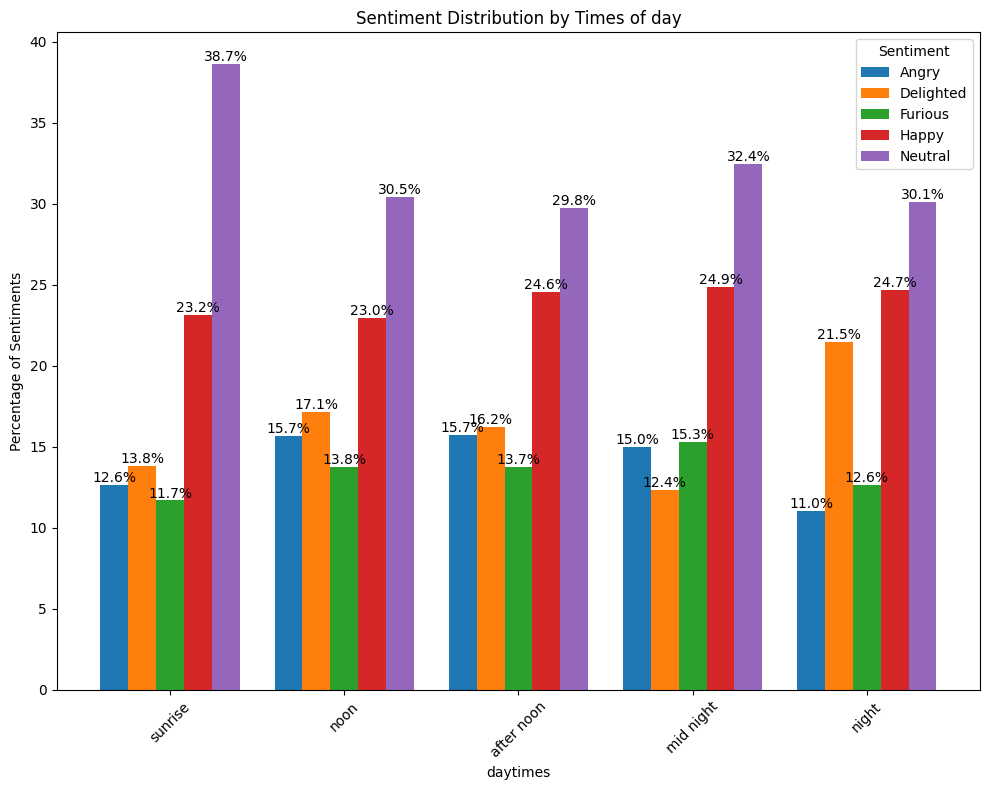

In [38]:
custom_order = ['sunrise','noon' , 'after noon', 'mid night', 'night']
df['time'] = pd.Categorical(df['time'], categories=custom_order, ordered=True)

grouped = df.groupby(['time', 'sentiment']).size().unstack(fill_value=0)

grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

ax = grouped_percent.plot(kind='bar', figsize=(10, 8), width=0.8)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.xlabel('daytimes')
plt.ylabel('Percentage of Sentiments')
plt.title('Sentiment Distribution by Times of day')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

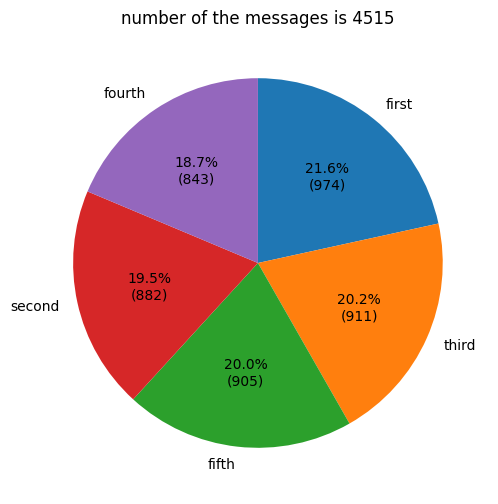

In [33]:
def func(pct, allvals):
    absolute = int(round(pct/100.*sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sentiment_counts = df['week_no'].value_counts()
plt.figure(figsize=(6, 6))
sentiment_counts.plot(kind='pie', autopct=lambda pct: func(pct, sentiment_counts), startangle=90, counterclock=False)
plt.ylabel('')
plt.title(f'number of the messages is {len(df)}')
plt.show()

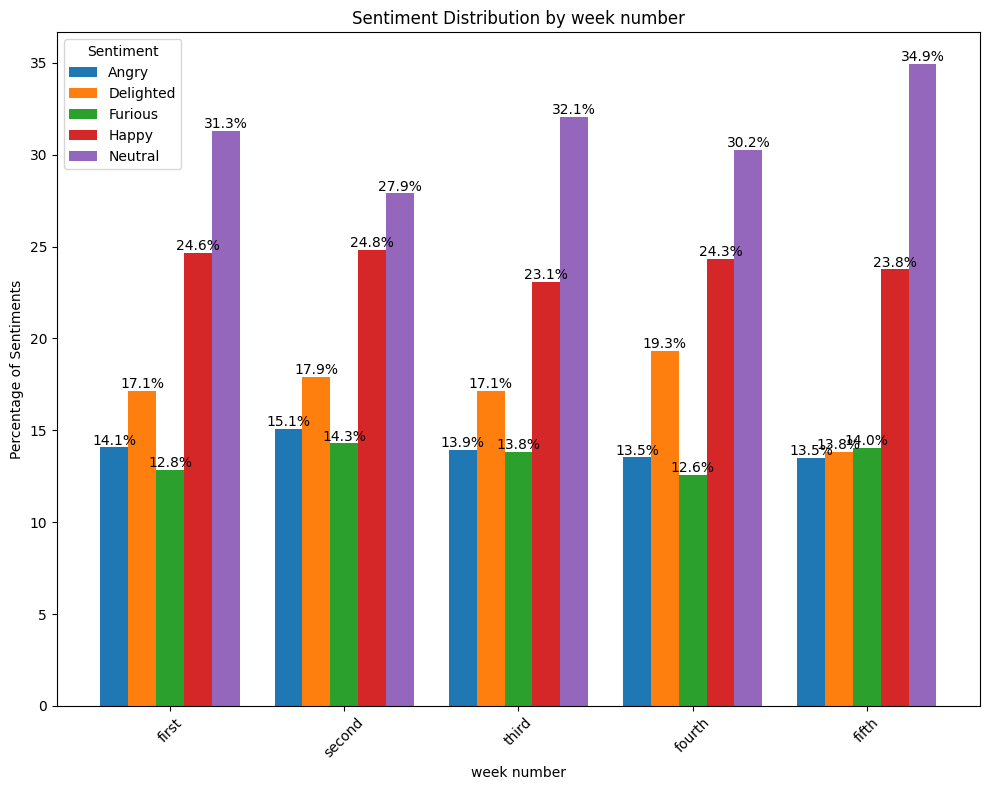

In [39]:
custom_order = ['first','second' , 'third', 'fourth', 'fifth']
df['week_no'] = pd.Categorical(df['week_no'], categories=custom_order, ordered=True)

grouped = df.groupby(['week_no', 'sentiment']).size().unstack(fill_value=0)

grouped_percent = grouped.div(grouped.sum(axis=1), axis=0) * 100

ax = grouped_percent.plot(kind='bar', figsize=(10, 8), width=0.8)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

plt.xlabel('week number')
plt.ylabel('Percentage of Sentiments')
plt.title('Sentiment Distribution by week number')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

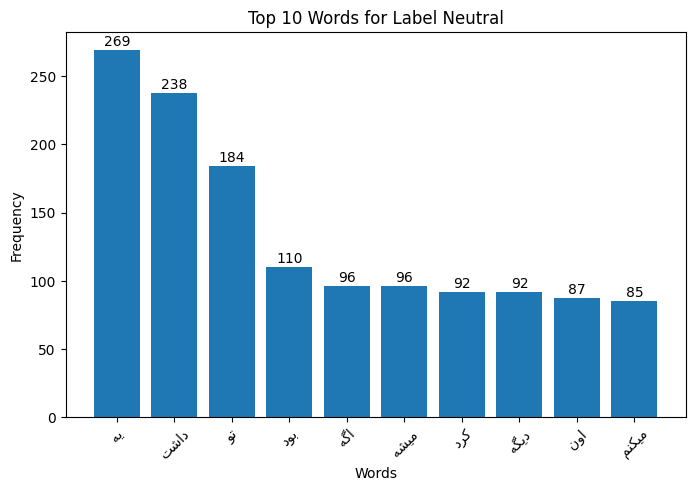

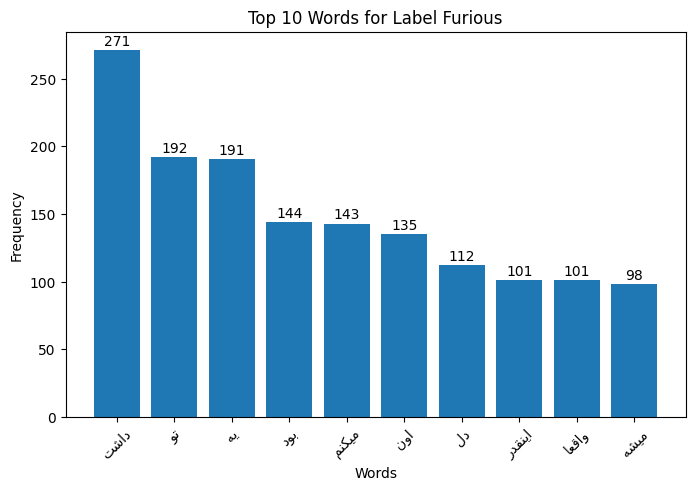

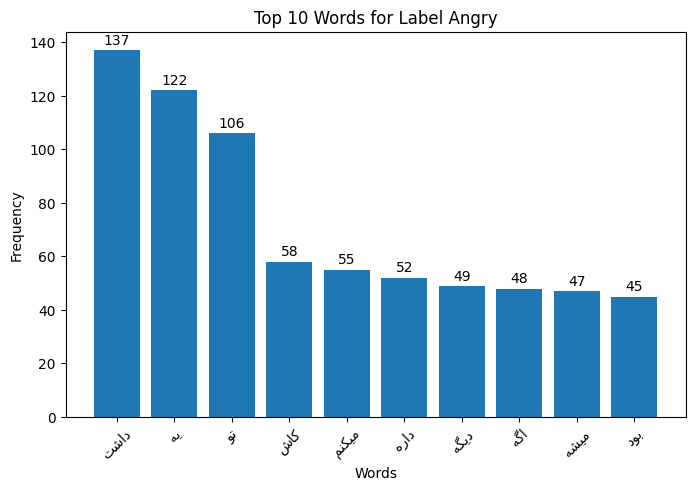

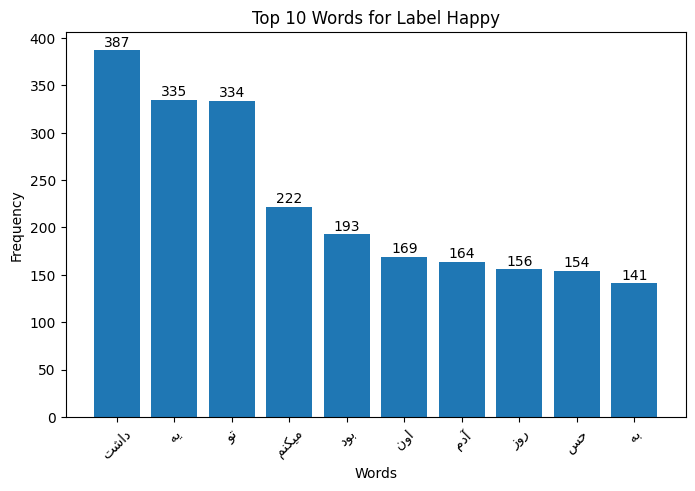

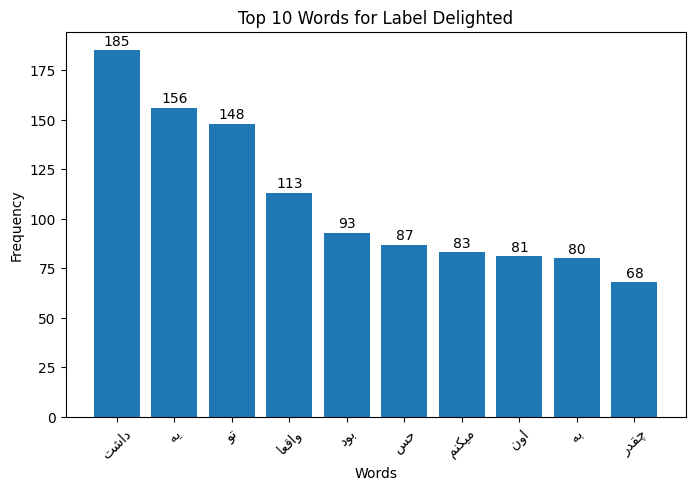

In [45]:
word_frequencies = {}

for label in df['sentiment'].unique():
    subset = df[df['sentiment'] == label]
    combined_text = ' '.join(subset['lemma_text'])
    tokens = word_tokenize(combined_text)
    word_freq = Counter(tokens)
    top_words = word_freq.most_common(10)
    word_frequencies[label] = top_words

for label, top_words in word_frequencies.items():
    words, frequencies = zip(*top_words)
    plt.figure(figsize=(8, 5))
    persian_words = [get_display(reshape(lab)) for lab in words]
    plt.bar(persian_words, frequencies)
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Words for Label {label}')
    plt.xticks(rotation=45)

    for i, freq in enumerate(frequencies):
        plt.text(i, freq + 1, str(freq), ha='center', va='bottom', fontsize=10)

    plt.show()

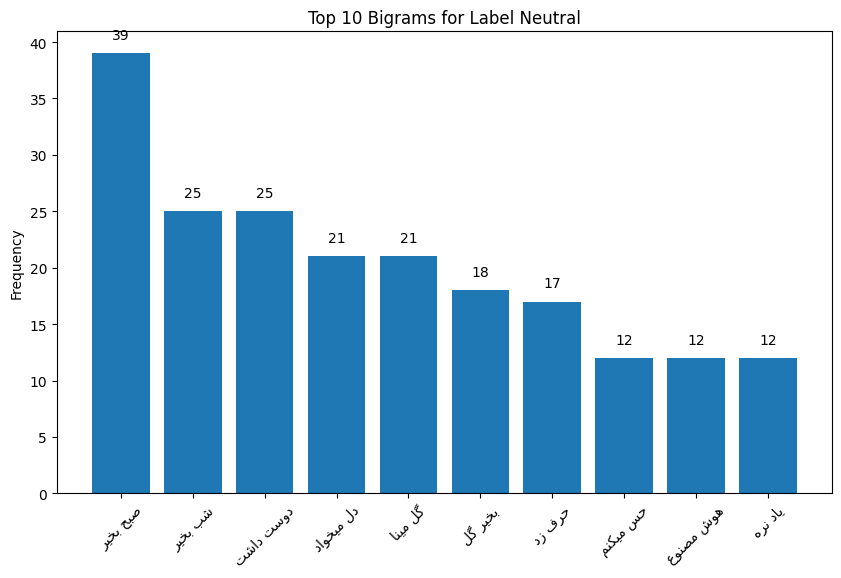

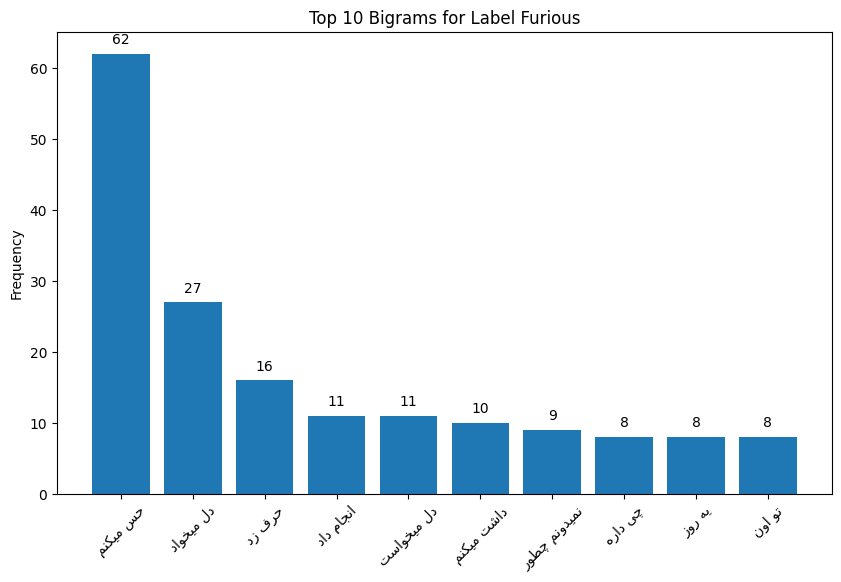

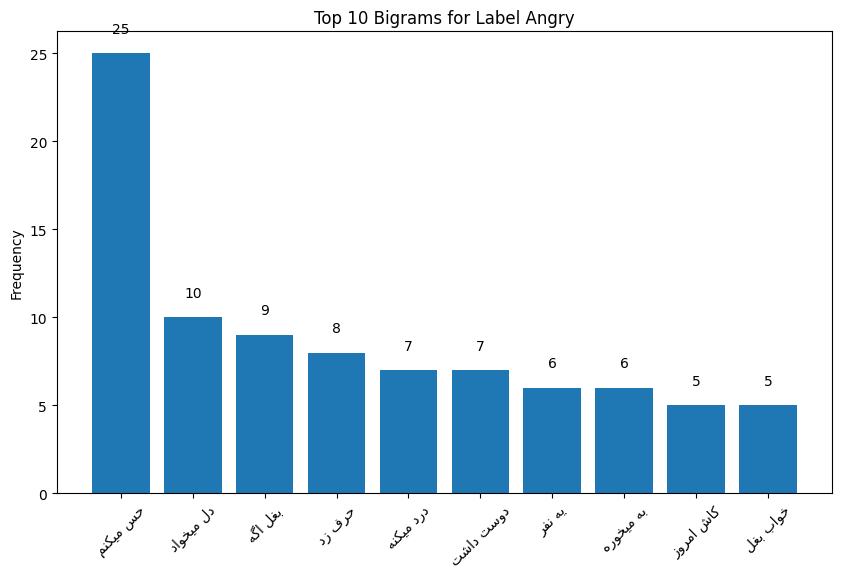

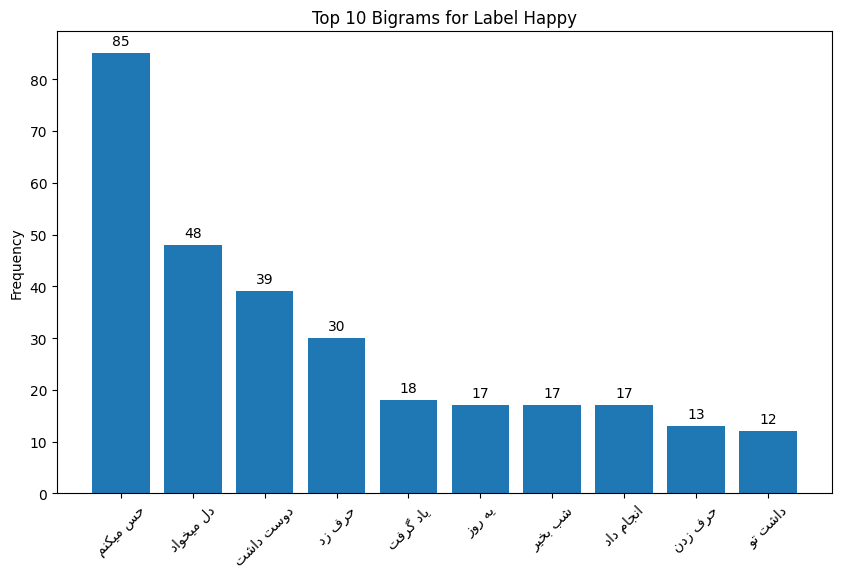

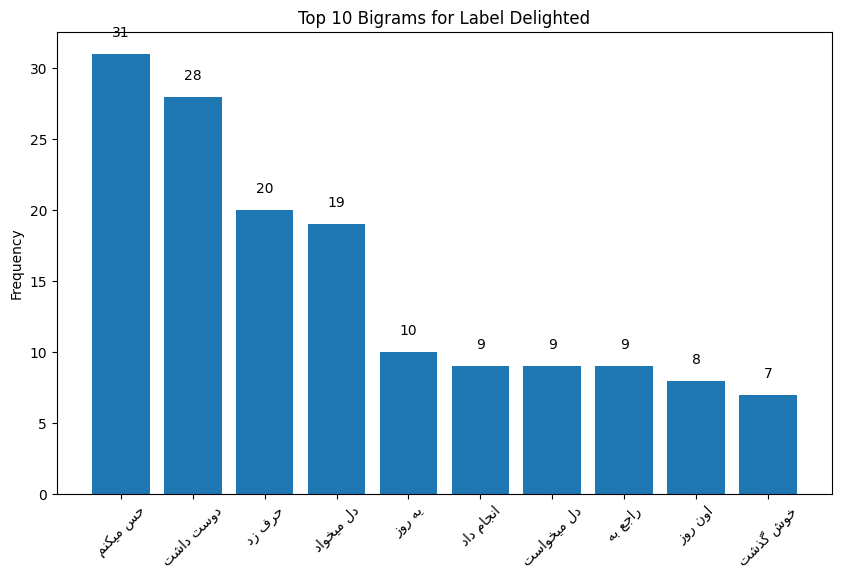

In [47]:
bigram_frequencies = {}

for label in df['sentiment'].unique():
    subset = df[df['sentiment'] == label]
    combined_text = ' '.join(subset['lemma_text'])
    tokens = word_tokenize(combined_text)
    bigrams = list(ngrams(tokens, 2))
    bigram_freq = Counter(bigrams)
    top_bigrams = bigram_freq.most_common(10)
    bigram_frequencies[label] = top_bigrams

for label, top_bigrams in bigram_frequencies.items():
    bigrams, frequencies = zip(*top_bigrams)
    bigram_labels = [' '.join(bigram) for bigram in bigrams]
    plt.figure(figsize=(10, 6))
    persian_bigrams = [get_display(reshape(bigram)) for bigram in bigram_labels]
    plt.bar(persian_bigrams, frequencies)
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Bigrams for Label {label}')
    plt.xticks(rotation=45)
    for i, freq in enumerate(frequencies):
        plt.text(i, freq + 1, str(freq), ha='center', va='bottom', fontsize=10)
    plt.show()

c:\Users\Mostafa\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 44316 (\N{HANGUL SYLLABLE GWAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Mostafa\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 52270 (\N{HANGUL SYLLABLE CANH}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Mostafa\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Mostafa\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51656 (\N{HANGUL SYLLABLE JIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Mostafa\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pyl

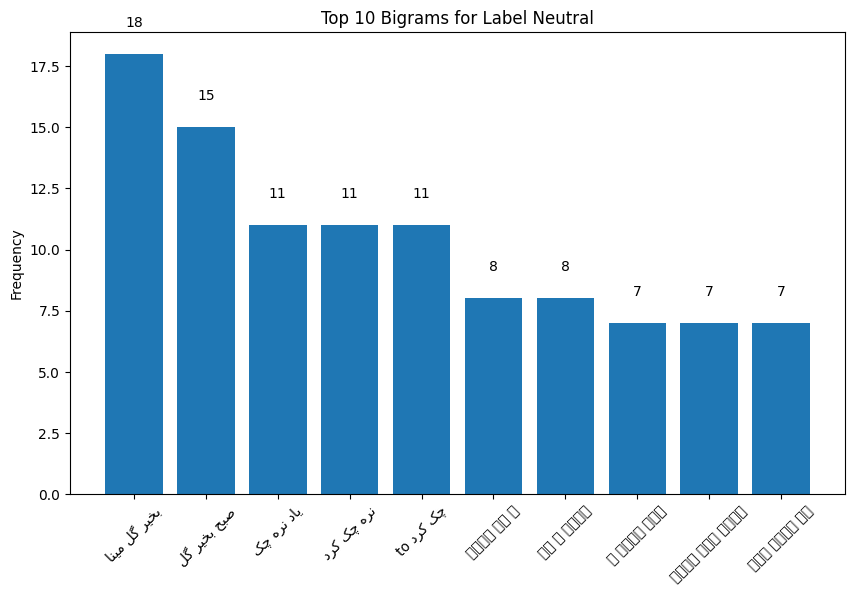

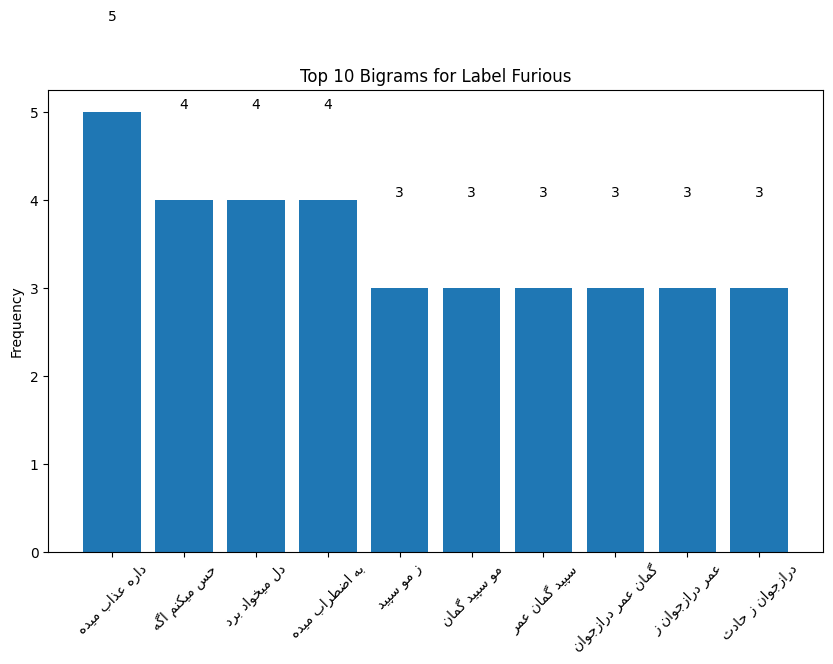

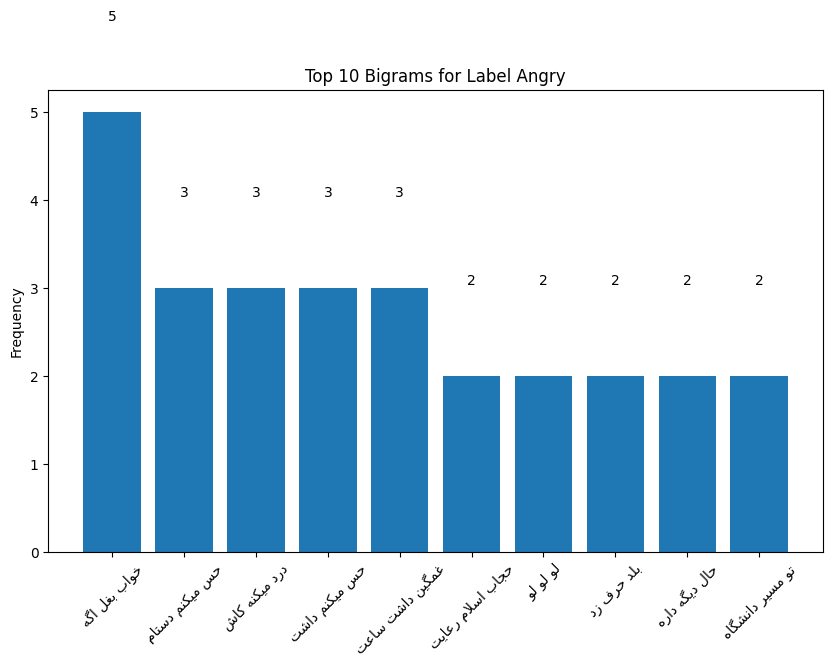

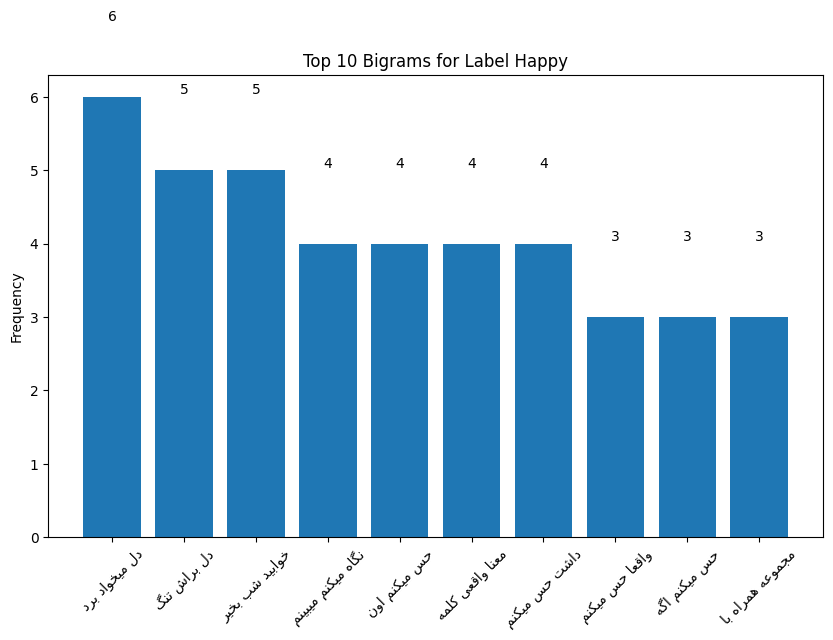

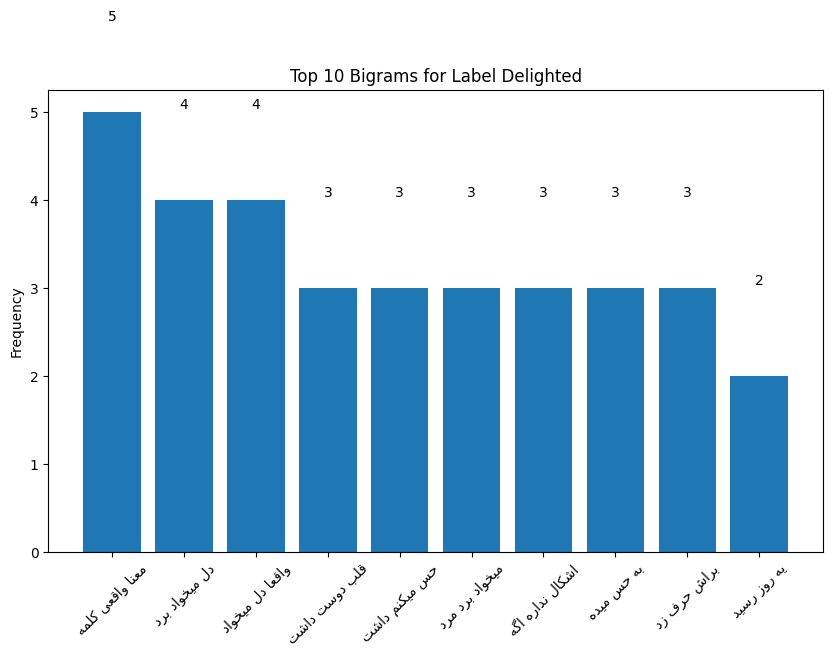

In [48]:
bigram_frequencies = {}

for label in df['sentiment'].unique():
    subset = df[df['sentiment'] == label]
    combined_text = ' '.join(subset['lemma_text'])
    tokens = word_tokenize(combined_text)
    bigrams = list(ngrams(tokens, 3))
    bigram_freq = Counter(bigrams)
    top_bigrams = bigram_freq.most_common(10)
    bigram_frequencies[label] = top_bigrams

for label, top_bigrams in bigram_frequencies.items():
    bigrams, frequencies = zip(*top_bigrams)
    bigram_labels = [' '.join(bigram) for bigram in bigrams]
    plt.figure(figsize=(10, 6))
    persian_bigrams = [get_display(reshape(bigram)) for bigram in bigram_labels]
    plt.bar(persian_bigrams, frequencies)
    plt.ylabel('Frequency')
    plt.title(f'Top 10 Bigrams for Label {label}')
    plt.xticks(rotation=45)
    for i, freq in enumerate(frequencies):
        plt.text(i, freq + 1, str(freq), ha='center', va='bottom', fontsize=10)
    plt.show()